In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
import pandas as pd
from lenstools.statistics.ensemble import Series,Ensemble
from lenstools.statistics.constraints import Emulator
from lenstools.statistics.contours import ContourPlot
from lenstools.statistics.samplers import emcee_sampler
from itertools import cycle
import seaborn as sns
import emcee
from matplotlib.colors import LogNorm
from multiprocessing import Pool
from scipy.stats import skew
from scipy.stats import kurtosis as kurt

%matplotlib inline

In [38]:
def standard_error_skew(n):
    return np.sqrt(6*n*(n-1)/((n-2)*(n+1)*(n+3)))


def standard_error_kurt(n):
    return np.sqrt(24*n*(n-1)**2/((n-3)*(n-2)*(n+3)*(n+5)))

def sample(n, kde_list, transformer):
    X = np.hstack([kde.sample(n) for kde in kde_list])
    return transformer.inverse_transform(X)

In [39]:
data = pd.read_csv('../powerspec.csv')
data.pop("Unnamed: 0")
ell_bins = [f"ell{i}" for i in range(37)]
ell = np.logspace(np.log10(500), np.log10(5000),37)
train_data = data[ell_bins].to_numpy()
_, unique_idx = np.unique(train_data, return_index=True,axis=0)
train_data = train_data[unique_idx]

mean = np.mean(train_data,axis=0)
centered_data = train_data - mean
BIG_cov = np.cov(train_data.T)
L = np.linalg.cholesky(np.linalg.inv(BIG_cov))
prepro_data = centered_data @ L
# prepro_data = np.log(train_data)

In [40]:
from sklearn.decomposition import FastICA, PCA
from sklearn.neighbors import KernelDensity

In [86]:
transformer = FastICA(n_components=37, random_state=0, tol=0.001, max_iter=300)
# transformer = PCA(n_components=37)
X = transformer.fit_transform(prepro_data)

In [87]:
kde_list = []

for i in range(X.shape[1]):
    X_transformed = KernelDensity(kernel='gaussian', 
                                  bandwidth=X.shape[0]**(-1/(X.shape[1]+4))).fit(X[:, i].reshape(-1, 1))
    kde_list.append(X_transformed)
    
kde_list = np.array(kde_list)

In [88]:
t_skew_real_set = []
t_kurt_real_set = []
t_skew_gmm_set = []
t_kurt_gmm_set = []

n_samples = 2048

SE_skew = standard_error_skew(n_samples)
SE_kurt = standard_error_kurt(n_samples)

for i in range(100):
    # Randomly sample from training data
    ind = np.random.randint(0,prepro_data.shape[0],n_samples)
    smp_real_data = prepro_data[ind] @ np.linalg.inv(L) + mean
    real_skew = skew(smp_real_data,axis=0)
    real_kurt = kurt(smp_real_data,axis=0)
    
    # Gmm was trained on log of data, so scale back to normal with np.exp
    #ind = np.random.randint(0,X_transformed.shape[0],n_samples)
    X_ica = sample(n_samples, kde_list, transformer)
    smp_gmm_data = X_ica @ np.linalg.inv(L) + mean
    gmm_skew = skew(smp_gmm_data,axis=0)
    gmm_kurt = kurt(smp_gmm_data,axis=0)
    
    t_skew_real = real_skew/SE_skew
    t_skew_real_set.append(t_skew_real)
    
    t_kurt_real = real_kurt/SE_kurt
    t_kurt_real_set.append(t_kurt_real)
    
    t_skew_gmm = gmm_skew/SE_skew
    t_skew_gmm_set.append(t_skew_gmm)
    
    t_kurt_gmm = gmm_kurt/SE_kurt
    t_kurt_gmm_set.append(t_kurt_gmm)

avg_t_skew_real = np.array(t_skew_real_set).mean(axis=0)
std_t_skew_real = np.array(t_skew_real_set).std(axis=0)

avg_t_kurt_real = np.array(t_kurt_real_set).mean(axis=0)
std_t_kurt_real = np.array(t_kurt_real_set).std(axis=0)

avg_t_skew_gmm = np.array(t_skew_gmm_set).mean(axis=0)
std_t_skew_gmm = np.array(t_skew_gmm_set).std(axis=0)

avg_t_kurt_gmm = np.array(t_kurt_gmm_set).mean(axis=0)
std_t_kurt_gmm = np.array(t_kurt_gmm_set).std(axis=0)

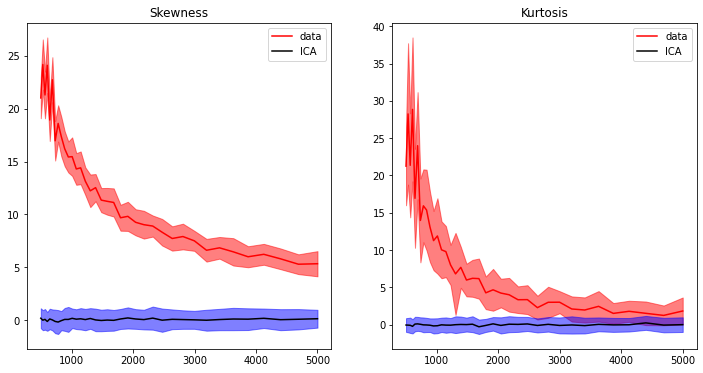

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(ell,avg_t_skew_real,'r-', label="data")
ax[0].fill_between(ell,avg_t_skew_real+std_t_skew_real,avg_t_skew_real-std_t_skew_real,alpha=0.5,color='r')
ax[0].plot(ell,avg_t_skew_gmm,'k-', label="ICA")
ax[0].fill_between(ell,avg_t_skew_gmm+std_t_skew_gmm,avg_t_skew_gmm-std_t_skew_gmm,alpha=0.5,color='b')

ax[1].plot(ell,avg_t_kurt_real,'r-', label="data")
ax[1].fill_between(ell,avg_t_kurt_real+std_t_kurt_real,avg_t_kurt_real-std_t_kurt_real,alpha=0.5,color='r')
ax[1].plot(ell,avg_t_kurt_gmm,'k-', label="ICA")
ax[1].fill_between(ell,avg_t_kurt_gmm+std_t_kurt_gmm,avg_t_kurt_gmm-std_t_kurt_gmm,alpha=0.5,color='b')

ax[0].legend()
ax[0].set_title("Skewness")

ax[1].set_title("Kurtosis")
ax[1].legend()

plt.show()

In [90]:
smp_gmm_data = np.exp(X_ica)
ells = smp_gmm_data.flatten()
ells = np.vstack((ells, np.tile(np.logspace(np.log10(500), np.log10(5000), 37), len(smp_gmm_data)))).T
l = ells[:, 1]
P = ells[:,0]

/home/alexandre/anaconda3/envs/fbl/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


/home/alexandre/anaconda3/envs/fbl/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


ValueError: autodetected range of [0.0, inf] is not finite

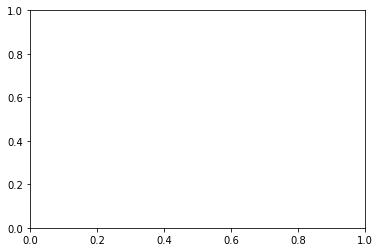

In [91]:
plt.figure()
counts,ybins,xbins,image = plt.hist2d(l,l*(l+1)*P, bins=100, cmap="jet", norm=LogNorm())